In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
df = pd.read_csv('articles.csv')
df.head(3)

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...


In [3]:
# Começando a tratar os dados

df = df.drop('subcategory', axis=1)
df.describe()

,title,text,date,category,link
count,167053,166288,167053,167053,167053
unique,164119,165901,987,48,167053
top,Quadrinhos,"Toda segunda-feira, ""Tec"" divulga os mais lega...",2015-03-15,poder,http://www1.folha.uol.com.br/mercado/2015/04/1...
freq,627,25,285,22022,1


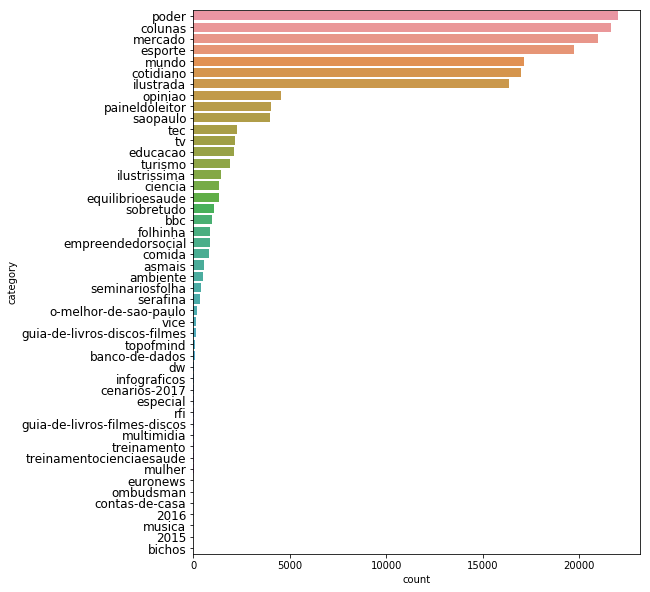

In [4]:
plt.figure(figsize=(8,10))

descending_order = df['category'].value_counts().sort_values(ascending=False).index

sns.countplot(
    y=df.category, 
    order=descending_order, 
    orient="v")

plt.yticks(fontsize=12)
plt.xticks(fontsize=10)
plt.show()

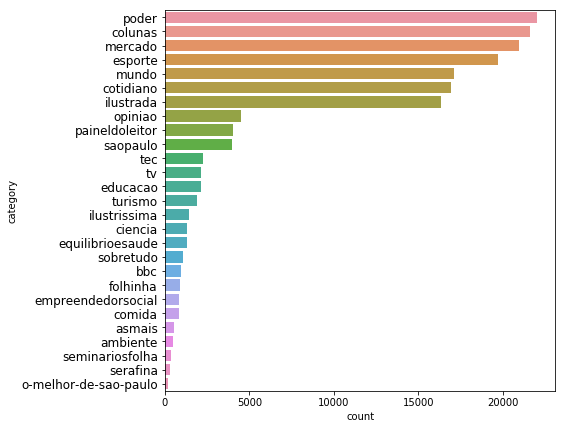

In [5]:
# Remover todas as categorias que tenham menos de 150 amostras.
category = df.groupby('category')['category'].count().sort_values(ascending=False)
category = category[category < 150]

for i in category.index:
    df = df[df.category != i]
    

# Plotando o grafico com as categorias x frequencia
plt.figure(figsize=(7,7))

descending_order = df['category'].value_counts().sort_values(ascending=False).index

sns.countplot(
    y=df.category, 
    order=descending_order, 
    orient="v")

plt.yticks(fontsize=12)
plt.xticks(fontsize=10)
plt.show()

In [6]:
#tratamento do texto

import re
from unicodedata import normalize

def remover_acentos(txt, codif='utf-8'):
    return normalize('NFKD', txt.decode(codif)).encode('ASCII', 'ignore')

def remover_numeros(txt):
    return re.sub('[0-9]', '', txt)

def remover_caracteres_especiais(txt):
    return re.sub('\W+',' ', txt )

def remover_stopwords(txt):
    sw = stopwords.words('portuguese')
    for i in sw:
        txt = txt.replace(' '+ i + ' ', ' ')
    return txt
    
def tratar_tudo(txt):
    txt = remover_acentos(txt)
    txt = remover_numeros(txt)
    txt = remover_caracteres_especiais(txt)
    txt = remover_stopwords(txt)
    return txt

df.text = df.text.apply(lambda x: tratar_tudo(str(x)))

print(df.text[:10])

0    Com possibilidade condenacao impedir candidatu...
1    Para Oumou Sangare cantora ativista malinesa s...
2    Tres reportagens Folha vencedoras Premio Petro...
3    A Disney divulgou noite desta segunda feira no...
4    O CBSS banco holding Elopar socios Bradesco Ba...
5    O vocalista banda irlandesa U Bono fez pergunt...
6    O italiano Cesare Battisti disse nesta segunda...
7    Pela primeira vez desde assumiu comando seleca...
8    O STF Supremo Tribunal Federal negou quinta fe...
9    O aplicativo mensagens instantaneas WhatsApp d...
Name: text, dtype: object


In [7]:
# Verificando como ficou
df.head(5)

,title,text,date,category,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com possibilidade condenacao impedir candidatu...,2017-09-10,poder,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...",Para Oumou Sangare cantora ativista malinesa s...,2017-09-10,ilustrada,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Tres reportagens Folha vencedoras Premio Petro...,2017-09-10,poder,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou noite desta segunda feira no...,2017-09-10,ilustrada,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,O CBSS banco holding Elopar socios Bradesco Ba...,2017-09-10,mercado,http://www1.folha.uol.com.br/mercado/2017/10/1...


In [8]:
df.text = df.text.str.lower()
text = ''.join(str(df.text))

print(text[:500])

0         com possibilidade condenacao impedir candidatu...
1         para oumou sangare cantora ativista malinesa s...
2         tres reportagens folha vencedoras premio petro...
3         a disney divulgou noite desta segunda feira no...
4         o cbss banco holding elopar socios bradesco ba...
5         o vocalista banda irlandesa u bono fez pergunt...
6         o italiano cesare battisti disse nesta segunda...
7         pela primeira vez desde assumiu comando seleca...
8         o stf supr


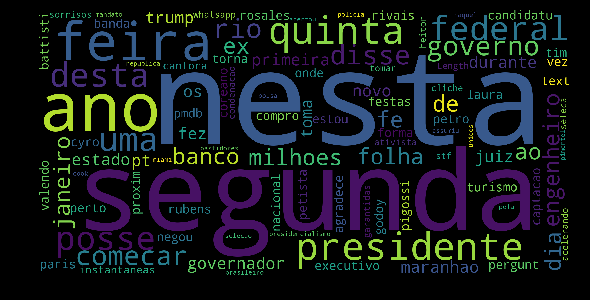

In [9]:
wordcloud = WordCloud(
    width=2500, 
    height=1250,
    max_words=100, 
    normalize_plurals= True
)
wordcloud.generate(text)
plt.figure(figsize=(8,5),facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [10]:
df.dropna() #remove as linhas que está faltando algum item (NaN)
X_train, X_test, y_train, y_test = train_test_split(df.text.fillna(' '), df.category)

In [11]:
vectorizer = CountVectorizer()

training_data = vectorizer.fit_transform(X_train)
testing_data = vectorizer.transform(X_test)

In [12]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

In [13]:
accuracy = accuracy_score(y_test, predictions)
print('Accuracy score: {0:.1f}%.'.format(accuracy * 100))

Accuracy score: 74.6%.


In [14]:
for foi, era in zip(predictions[20:30], y_test[20:30]):
    print("%s | Foi classificado como [%s], mas era [%s]" % (('Certo' if foi == era else ' -> Errado') ,foi, era))

 -> Errado | Foi classificado como [poder], mas era [mercado]
 -> Errado | Foi classificado como [ilustrada], mas era [colunas]
Certo | Foi classificado como [poder], mas era [poder]
Certo | Foi classificado como [mundo], mas era [mundo]
Certo | Foi classificado como [cotidiano], mas era [cotidiano]
Certo | Foi classificado como [esporte], mas era [esporte]
Certo | Foi classificado como [cotidiano], mas era [cotidiano]
Certo | Foi classificado como [ilustrada], mas era [ilustrada]
Certo | Foi classificado como [cotidiano], mas era [cotidiano]
 -> Errado | Foi classificado como [poder], mas era [mercado]


In [15]:
# Criando um Pipeline - Classificador Composto
# vectorizer => transformer => classifier 
text_clf = Pipeline([('vect', CountVectorizer(stop_words = stopwords.words('portuguese'), 
                                              binary = True)),
                     ('clf', MultinomialNB()),])

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=[u'de', u...enizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [16]:
predictions2 = text_clf.predict(X_test)

In [17]:
accuracy2 = accuracy_score(y_test, predictions2)
print('Accuracy score: {0:.1f}%.'.format(accuracy2 * 100))

Accuracy score: 72.7%.


In [18]:
# Parâmetros para o GridSearchCV
parameters = {'clf__alpha': [0.01,0.1,1]}

# GridSearchCV
gs_clf = GridSearchCV(text_clf, parameters, n_jobs = -1)

In [19]:
#sa porra demora mto
gs_clf = gs_clf.fit(X_train, y_train)

In [20]:
best_clf = gs_clf.best_estimator_
best_predict = best_clf.predict(X_test)

In [21]:
accuracy3 = accuracy_score(y_test, best_predict)
print('Accuracy score: {0:.1f}%.'.format(accuracy3 * 100))
print('Best Parans ' + str(gs_clf.best_params_))

Accuracy score: 75.4%.
Best Parans {'clf__alpha': 0.01}


In [22]:
df.head()

,title,text,date,category,link
0,"Lula diz que está 'lascado', mas que ainda tem...",com possibilidade condenacao impedir candidatu...,2017-09-10,poder,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...",para oumou sangare cantora ativista malinesa s...,2017-09-10,ilustrada,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,tres reportagens folha vencedoras premio petro...,2017-09-10,poder,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,a disney divulgou noite desta segunda feira no...,2017-09-10,ilustrada,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,o cbss banco holding elopar socios bradesco ba...,2017-09-10,mercado,http://www1.folha.uol.com.br/mercado/2017/10/1...


In [23]:
# Tokenizing
cv = CountVectorizer()
X_train_counts = cv.fit_transform(X_train)
X_train_counts.shape

(124710, 278303)

In [24]:
# Mesmo resultado da célula anterior, mas combinando as funções
tt = TfidfTransformer()
X_train_tfidf = tt.fit_transform(X_train_counts)
X_train_tfidf.shape

(124710, 278303)

In [25]:
# Criando o modelo Multinomial
clf = MultinomialNB(alpha=0.1).fit(X_train_tfidf, y_train)

In [26]:
X_new_counts = cv.transform(X_test)
X_new_tfidf = tt.transform(X_new_counts)

pred = clf.predict(X_new_tfidf)

In [27]:
accuracy_final = accuracy_score(y_test, pred)
print('Accuracy score: {0:.1f}%.'.format(accuracy_final * 100))

Accuracy score: 72.7%.


In [28]:
qtd_categorias_total = df.category.size

dic = []
dic = dict([ (j, i) for i,j in zip(range(df['category'].value_counts().index.size), df['category'].value_counts().index) ])
   
#Define uma função genérica usando a função replace
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded
 
#Codificando:
print('Antes Coding:')
print(pd.value_counts(df["category"]))
df["category"] = coding(df["category"], dic)
print('\nDepois Coding:')
print(pd.value_counts(df["category"]))


Antes Coding:
poder                    22022
colunas                  21622
mercado                  20970
esporte                  19730
mundo                    17130
cotidiano                16967
ilustrada                16345
opiniao                   4525
paineldoleitor            4011
saopaulo                  3955
tec                       2260
tv                        2142
educacao                  2118
turismo                   1903
ilustrissima              1411
ciencia                   1335
equilibrioesaude          1312
sobretudo                 1057
bbc                        980
folhinha                   876
empreendedorsocial         841
comida                     828
asmais                     548
ambiente                   491
seminariosfolha            379
serafina                   334
o-melhor-de-sao-paulo      189
Name: category, dtype: int64

Depois Coding:
0     22022
1     21622
2     20970
3     19730
4     17130
5     16967
6     16345
7      4525
8      4

In [29]:
df.head()

,title,text,date,category,link
0,"Lula diz que está 'lascado', mas que ainda tem...",com possibilidade condenacao impedir candidatu...,2017-09-10,0,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...",para oumou sangare cantora ativista malinesa s...,2017-09-10,6,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,tres reportagens folha vencedoras premio petro...,2017-09-10,0,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,a disney divulgou noite desta segunda feira no...,2017-09-10,6,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,o cbss banco holding elopar socios bradesco ba...,2017-09-10,2,http://www1.folha.uol.com.br/mercado/2017/10/1...


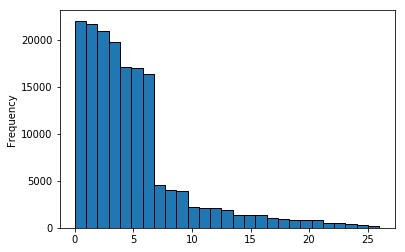

In [30]:
df["category"].plot.hist(bins=df.category.value_counts().index.size, edgecolor='black')

In [31]:
X_treino, X_teste, y_treino, y_teste = train_test_split(df.text, df.category)

#Matriz de Frequencia
ContadorVetor = CountVectorizer()
dados_de_treino = ContadorVetor.fit_transform(X_treino)
dados_de_teste = ContadorVetor.transform(X_teste)

# Normalização da Matriz de frequencia
TFrequencia = TfidfTransformer(use_idf=True, norm='l2')
dados_de_treino_frequenciado = TFrequencia.fit_transform(dados_de_treino)
dados_de_teste_frequenciado = TFrequencia.fit(dados_de_teste)

clf_final = MultinomialNB(alpha=0.01)
clf_final.fit(dados_de_treino_frequenciado, y_treino)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [32]:
pred_final = clf_final.predict(dados_de_teste)

In [33]:
ac_final = accuracy_score(y_teste, pred_final)
print('Accuracy score final: {0:.1f}%.'.format(ac_final * 100))

Accuracy score final: 76.1%.


In [35]:
from sklearn.linear_model import SGDClassifier

sgc_clf = SGDClassifier()
sgc_clf.fit(dados_de_treino_frequenciado, y_treino)

C:\Users\dfabiano\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [36]:
pred_sgc = sgc_clf.predict(dados_de_teste)

ac_sgc = accuracy_score(y_teste, pred_sgc)
print('Accuracy score final: {0:.1f}%.'.format(ac_sgc * 100))

Accuracy score final: 78.2%.


In [62]:
param = {
    'alpha': (0.00001, 0.000001, 1),
    'penalty': ('l2', 'elasticnet'),
}

grid_search = GridSearchCV(sgc_clf, param, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(dados_de_treino_frequenciado, y_treino)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ('l2', 'elasticnet'), 'alpha': (1e-05, 1e-06, 1)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [63]:
grid_search.best_params_

{'alpha': 1e-05, 'penalty': 'l2'}

In [64]:
sgd_clg_best = SGDClassifier(alpha=1e-05, penalty='l2')

sgd_clg_best.fit(dados_de_treino_frequenciado, y_treino)

SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [65]:
pred_sgd_best = sgd_clg_best.predict(dados_de_teste)

ac_sgd_best = accuracy_score(y_teste, pred_sgd_best)
print('Accuracy score final: {0:.1f}%.'.format(ac_sgd_best * 100))

Accuracy score final: 81.7%.
